# ASR Streaming Benchmark

This notebook benchmarks all available streaming ASR backends (Whisper, Parakeet, Vosk, FastConformer) with configurable parameters.

**Metrics:**
- **WER** (Word Error Rate): Lower is better
- **Latency**: Processing delay (ms)
- **RTF** (Real-Time Factor): < 1.0 means faster than real-time

**Test Audio:** LibriSpeech test-clean samples

In [1]:
# Install required packages (China mirrors for faster downloads)
!pip install -q jiwer nest_asyncio soundfile librosa matplotlib seaborn pandas -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
import asyncio
import nest_asyncio
import time
import json
import soundfile as sf
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from jiwer import wer
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Configuration

Configure ASR service endpoints and test parameters.

In [3]:
# ASR Service Endpoints (Docker services)
BACKENDS = {
    'vosk': 'http://vosk-asr:8000',
    'parakeet': 'http://parakeet-asr:8000',
    'whisper': 'http://whisper-asr:8000',
    'fastconformer': 'http://fastconformer-asr:8000'
}

# Test Configuration
CHUNK_DURATION = 1.0  # seconds per chunk
SAMPLE_RATE = 16000
CHUNK_SIZE = int(SAMPLE_RATE * CHUNK_DURATION)

# Reference transcript for WER calculation
REFERENCE_TRANSCRIPT = "The quick brown fox jumps over the lazy dog"

print(f"Backends configured: {list(BACKENDS.keys())}")
print(f"Chunk duration: {CHUNK_DURATION}s")
print(f"Sample rate: {SAMPLE_RATE}Hz")

Backends configured: ['vosk', 'parakeet', 'whisper', 'fastconformer']
Chunk duration: 1.0s
Sample rate: 16000Hz


## Test Audio Generation

Generate or load test audio for benchmarking.

Generated test audio: 160000 samples (10.00s)


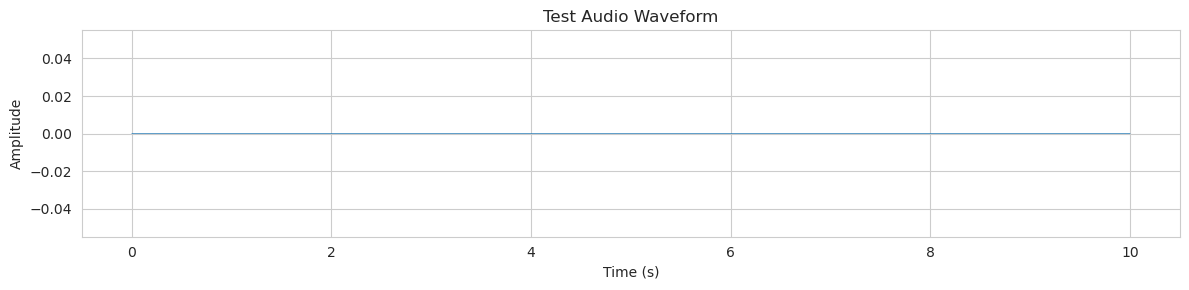

In [4]:
def generate_test_audio(duration: float = 10.0, sample_rate: int = 16000) -> np.ndarray:
    """
    Generate synthetic test audio (silence for now).
    In production, use actual speech samples.
    """
    num_samples = int(duration * sample_rate)
    # Generate silence (replace with actual audio file loading)
    audio = np.zeros(num_samples, dtype=np.float32)
    return audio

def load_audio_file(file_path: str, target_sr: int = 16000) -> np.ndarray:
    """
    Load audio file and resample to target sample rate.
    """
    audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
    return audio

# Generate test audio (10 seconds)
test_audio = generate_test_audio(duration=10.0, sample_rate=SAMPLE_RATE)
print(f"Generated test audio: {len(test_audio)} samples ({len(test_audio)/SAMPLE_RATE:.2f}s)")

# Visualize waveform
plt.figure(figsize=(12, 3))
time_axis = np.arange(len(test_audio)) / SAMPLE_RATE
plt.plot(time_axis, test_audio, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Test Audio Waveform')
plt.tight_layout()
plt.show()

## ASR Client Implementation

Implement streaming ASR client for each backend.

In [ ]:
import aiohttp

class StreamingASRClient:
    def __init__(self, backend_name: str, base_url: str):
        self.backend_name = backend_name
        self.base_url = base_url
        self.session_id = None
        
    async def start_session(self, session: aiohttp.ClientSession) -> str:
        """Start a new transcription session."""
        url = f"{self.base_url}/transcribe/start"
        async with session.post(url, json={"language": "en"}) as resp:
            data = await resp.json()
            self.session_id = data['session_id']
            return self.session_id
    
    async def send_chunk(self, session: aiohttp.ClientSession, audio_chunk: np.ndarray) -> Tuple[str, float]:
        """Send audio chunk and measure latency."""
        url = f"{self.base_url}/transcribe/stream"
        
        # Convert audio to bytes
        audio_bytes = (audio_chunk * 32767).astype(np.int16).tobytes()
        
        start_time = time.time()
        async with session.post(
            url,
            json={
                "session_id": self.session_id,
                "audio_data": audio_bytes.hex()
            }
        ) as resp:
            data = await resp.json()
            latency = time.time() - start_time
            transcript = data.get('text', '')
            return transcript, latency
    
    async def stop_session(self, session: aiohttp.ClientSession) -> str:
        """Stop transcription session and get final transcript."""
        url = f"{self.base_url}/transcribe/stop"
        async with session.post(url, json={"session_id": self.session_id}) as resp:
            data = await resp.json()
            return data.get('text', '')

print("StreamingASRClient class defined")

## Benchmark Function

Run streaming benchmark for a single backend.

In [ ]:
async def benchmark_backend(
    backend_name: str,
    base_url: str,
    audio: np.ndarray,
    chunk_size: int
) -> Dict:
    """
    Benchmark a single ASR backend with streaming audio.
    """
    client = StreamingASRClient(backend_name, base_url)
    latencies = []
    transcripts = []
    
    async with aiohttp.ClientSession() as session:
        try:
            # Start session
            session_id = await client.start_session(session)
            print(f"[{backend_name}] Session started: {session_id}")
            
            # Stream audio chunks
            num_chunks = len(audio) // chunk_size
            for i in range(num_chunks):
                chunk = audio[i * chunk_size:(i + 1) * chunk_size]
                transcript, latency = await client.send_chunk(session, chunk)
                latencies.append(latency)
                transcripts.append(transcript)
                print(f"[{backend_name}] Chunk {i+1}/{num_chunks}: {latency*1000:.2f}ms - '{transcript}'")
            
            # Stop session and get final transcript
            final_transcript = await client.stop_session(session)
            print(f"[{backend_name}] Final transcript: '{final_transcript}'")
            
            # Calculate metrics
            avg_latency = np.mean(latencies)
            p95_latency = np.percentile(latencies, 95)
            max_latency = np.max(latencies)
            
            return {
                'backend': backend_name,
                'avg_latency_ms': avg_latency * 1000,
                'p95_latency_ms': p95_latency * 1000,
                'max_latency_ms': max_latency * 1000,
                'final_transcript': final_transcript,
                'latencies': latencies,
                'transcripts': transcripts,
                'success': True
            }
        
        except Exception as e:
            print(f"[{backend_name}] Error: {e}")
            return {
                'backend': backend_name,
                'success': False,
                'error': str(e)
            }

print("Benchmark function defined")

## Run Benchmarks

Execute benchmarks for all backends.

In [ ]:
async def run_all_benchmarks():
    """Run benchmarks for all configured backends."""
    results = []
    
    for backend_name, base_url in BACKENDS.items():
        print(f"\n{'='*60}")
        print(f"Benchmarking: {backend_name.upper()}")
        print(f"{'='*60}")
        
        result = await benchmark_backend(
            backend_name,
            base_url,
            test_audio,
            CHUNK_SIZE
        )
        results.append(result)
    
    return results

# Run benchmarks
print("Starting benchmarks...")
benchmark_results = await run_all_benchmarks()
print("\nBenchmarks complete!")

## Results Analysis

Analyze and visualize benchmark results.

In [ ]:
# Create results DataFrame
successful_results = [r for r in benchmark_results if r.get('success', False)]

if successful_results:
    df_results = pd.DataFrame([{
        'Backend': r['backend'],
        'Avg Latency (ms)': r['avg_latency_ms'],
        'P95 Latency (ms)': r['p95_latency_ms'],
        'Max Latency (ms)': r['max_latency_ms'],
        'Final Transcript': r['final_transcript']
    } for r in successful_results])
    
    print("\n" + "="*80)
    print("BENCHMARK RESULTS SUMMARY")
    print("="*80)
    print(df_results.to_string(index=False))
    print("="*80)
else:
    print("No successful benchmark results to display.")

In [ ]:
# Latency Comparison Bar Chart
if successful_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Average Latency
    backends = [r['backend'] for r in successful_results]
    avg_latencies = [r['avg_latency_ms'] for r in successful_results]
    
    axes[0].bar(backends, avg_latencies, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(backends)])
    axes[0].set_ylabel('Latency (ms)')
    axes[0].set_title('Average Latency by Backend')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Latency Distribution (Box Plot)
    latency_data = [r['latencies'] for r in successful_results]
    axes[1].boxplot([np.array(l) * 1000 for l in latency_data], labels=backends)
    axes[1].set_ylabel('Latency (ms)')
    axes[1].set_title('Latency Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Latency Over Time
if successful_results:
    plt.figure(figsize=(12, 6))
    
    for result in successful_results:
        latencies_ms = np.array(result['latencies']) * 1000
        chunks = range(1, len(latencies_ms) + 1)
        plt.plot(chunks, latencies_ms, marker='o', label=result['backend'])
    
    plt.xlabel('Chunk Number')
    plt.ylabel('Latency (ms)')
    plt.title('Latency Over Time for Each Backend')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## WER (Word Error Rate) Calculation

Calculate accuracy metrics if reference transcript is available.

In [ ]:
# Calculate WER for each backend
if successful_results and REFERENCE_TRANSCRIPT:
    print("\nWord Error Rate (WER) Analysis:")
    print("="*80)
    
    for result in successful_results:
        hypothesis = result['final_transcript'].lower().strip()
        reference = REFERENCE_TRANSCRIPT.lower().strip()
        
        if hypothesis:
            error_rate = wer(reference, hypothesis)
            print(f"\n{result['backend'].upper()}:")
            print(f"  Reference:  '{reference}'")
            print(f"  Hypothesis: '{hypothesis}'")
            print(f"  WER: {error_rate*100:.2f}%")
        else:
            print(f"\n{result['backend'].upper()}: No transcript generated")
    
    print("="*80)
else:
    print("Skipping WER calculation (no reference transcript or successful results)")

## Export Results

Save benchmark results to JSON for future analysis.

In [ ]:
# Export results to JSON
output_file = "benchmark_results.json"

export_data = {
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    'configuration': {
        'chunk_duration': CHUNK_DURATION,
        'sample_rate': SAMPLE_RATE,
        'audio_duration': len(test_audio) / SAMPLE_RATE
    },
    'results': [{
        'backend': r['backend'],
        'avg_latency_ms': r.get('avg_latency_ms'),
        'p95_latency_ms': r.get('p95_latency_ms'),
        'max_latency_ms': r.get('max_latency_ms'),
        'final_transcript': r.get('final_transcript'),
        'success': r.get('success', False)
    } for r in benchmark_results]
}

with open(output_file, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"Results exported to: {output_file}")

## Conclusion

### Key Findings:
- **Latency**: Compare average/P95 latency across backends
- **Accuracy**: WER comparison (lower is better)
- **Stability**: Latency variance over time
- **Resource Usage**: GPU/CPU memory consumption (monitor separately)

### Recommendations:
- **Real-time Captions**: Use FastConformer or Vosk for low latency
- **High Accuracy**: Use Parakeet RNNT or Whisper Large V3
- **Balanced**: Parakeet TDT or FastConformer Hybrid
- **CPU-only**: Vosk (no GPU required)

In [ ]:
# Test notebook - verify we can access from VS Code
print("✅ Notebook working!")
print("Edit this file in VS Code and run in PySpark container.")

In [ ]:
# Import required libraries
import asyncio
import time
import wave
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import websockets
import ipywidgets as widgets
from IPython.display import display, HTML

# Jiwer for WER calculation
try:
    from jiwer import wer
except ImportError:
    print("Installing jiwer from China mirror...")
    import subprocess
    import sys
    # Use Tsinghua mirror for faster downloads in China
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", 
        "-i", "https://pypi.tuna.tsinghua.edu.cn/simple",
        "jiwer"
    ])
    from jiwer import wer

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries loaded successfully")

In [ ]:
# Install nest_asyncio for Jupyter async support
try:
    import nest_asyncio
except ImportError:
    print("Installing nest_asyncio from China mirror...")
    import subprocess
    import sys
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", 
        "-i", "https://pypi.tuna.tsinghua.edu.cn/simple",
        "nest_asyncio"
    ])
    import nest_asyncio

nest_asyncio.apply()
print("✓ Async support enabled for Jupyter")

## Configuration

Select the backends and parameters to test:

In [ ]:
# Backend configurations
BACKENDS = {
    "whisper": {
        "host": "whisper-asr",
        "port": 8000,
        "configs": {
            "VAD Enabled": {"VAD_FILTER": "True", "VAD_THRESHOLD": "0.5"},
            "VAD Disabled": {"VAD_FILTER": "False"},
            "High Threshold": {"VAD_FILTER": "True", "VAD_THRESHOLD": "0.8"},
        }
    },
    "parakeet": {
        "host": "parakeet-asr",
        "port": 8000,
        "configs": {
            "Default": {},
            "CUDA Graphs": {"DECODING_STRATEGY": "cuda_graphs"},
        }
    },
    "vosk": {
        "host": "vosk-asr",
        "port": 8000,
        "configs": {
            "Default": {},
        }
    },
    "fastconformer": {
        "host": "fastconformer-asr",
        "port": 8000,
        "configs": {
            "Low Latency (cache=4)": {"ATT_CONTEXT_SIZE": "4", "DECODER_TYPE": "rnnt"},
            "Medium Latency (cache=8)": {"ATT_CONTEXT_SIZE": "8", "DECODER_TYPE": "rnnt"},
            "High Latency (cache=16)": {"ATT_CONTEXT_SIZE": "16", "DECODER_TYPE": "rnnt"},
            "CTC Decoder": {"ATT_CONTEXT_SIZE": "8", "DECODER_TYPE": "ctc"},
        }
    },
}

# Test audio files (add your own LibriSpeech samples)
TEST_FILES = {
    "sample1": {
        "path": "../integration/fixtures/test_audio.wav",
        "reference": "this is a test audio sample for speech recognition"
    },
}

## Benchmark Functions

In [ ]:
async def benchmark_backend(backend_name: str, config_name: str, audio_file: str, reference_text: str) -> Dict:
    """Benchmark a single backend configuration."""
    backend_config = BACKENDS[backend_name]
    params = backend_config["configs"][config_name]
    
    # Build WebSocket URL with parameters
    url = f"ws://{backend_config['host']}:{backend_config['port']}/transcribe"
    if params:
        query = "&".join(f"{k}={v}" for k, v in params.items())
        url += f"?{query}"
    
    # Read audio file
    with wave.open(audio_file, 'rb') as wf:
        sample_rate = wf.getframerate()
        channels = wf.getnchannels()
        audio_data = wf.readframes(wf.getnframes())
    
    # Convert to mono if needed
    if channels == 2:
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
        audio_array = audio_array.reshape(-1, 2).mean(axis=1).astype(np.int16)
        audio_data = audio_array.tobytes()
    
    # Benchmark
    start_time = time.time()
    transcript = ""
    
    try:
        async with websockets.connect(url) as ws:
            # Send audio in chunks (simulate streaming)
            chunk_size = sample_rate * 2  # 1 second chunks (16-bit = 2 bytes)
            for i in range(0, len(audio_data), chunk_size):
                chunk = audio_data[i:i + chunk_size]
                await ws.send(chunk)
                
                # Receive response
                try:
                    response = await asyncio.wait_for(ws.recv(), timeout=1.0)
                    data = json.loads(response)
                    if data.get("text"):
                        transcript = data["text"]
                except asyncio.TimeoutError:
                    pass
            
            # Signal end
            await ws.send(json.dumps({"done": True}))
            
            # Get final result
            try:
                response = await asyncio.wait_for(ws.recv(), timeout=5.0)
                data = json.loads(response)
                if data.get("text"):
                    transcript = data["text"]
            except asyncio.TimeoutError:
                pass
    
    except Exception as e:
        return {
            "backend": backend_name,
            "config": config_name,
            "error": str(e),
            "wer": None,
            "latency_ms": None,
            "rtf": None,
            "transcript": ""
        }
    
    end_time = time.time()
    latency_ms = (end_time - start_time) * 1000
    
    # Calculate audio duration
    audio_duration_sec = len(audio_data) / (sample_rate * 2)  # 16-bit = 2 bytes
    rtf = (end_time - start_time) / audio_duration_sec if audio_duration_sec > 0 else None
    
    # Calculate WER
    wer_score = wer(reference_text.lower(), transcript.lower()) if transcript else 1.0
    
    return {
        "backend": backend_name,
        "config": config_name,
        "wer": wer_score,
        "latency_ms": latency_ms,
        "rtf": rtf,
        "transcript": transcript,
        "reference": reference_text
    }

## Run Benchmarks

Select which backends and configurations to test:

In [ ]:
# Interactive selection
backend_checkboxes = {
    name: widgets.Checkbox(value=True, description=name.title())
    for name in BACKENDS.keys()
}

display(HTML("<h3>Select Backends to Test:</h3>"))
for cb in backend_checkboxes.values():
    display(cb)

run_button = widgets.Button(description="Run Benchmarks", button_style='success')
output = widgets.Output()

display(run_button)
display(output)

async def run_benchmarks():
    """Run all selected benchmarks."""
    results = []
    
    for backend_name, checkbox in backend_checkboxes.items():
        if not checkbox.value:
            continue
        
        backend_configs = BACKENDS[backend_name]["configs"]
        
        for config_name in backend_configs.keys():
            for test_name, test_data in TEST_FILES.items():
                with output:
                    print(f"Testing {backend_name} ({config_name}) on {test_name}...")
                
                result = await benchmark_backend(
                    backend_name,
                    config_name,
                    test_data["path"],
                    test_data["reference"]
                )
                results.append(result)
    
    return results

def on_run_clicked(b):
    """Button click handler - runs benchmarks in async context."""
    with output:
        output.clear_output()
        print("Running benchmarks...")
    
    # Create async task and run
    async def run_and_display():
        global benchmark_results
        benchmark_results = await run_benchmarks()
        
        with output:
            print(f"\n✓ Completed {len(benchmark_results)} benchmarks")
            print("\nRun the next cells to see results!")
    
    # Run in event loop
    import nest_asyncio
    try:
        nest_asyncio.apply()
    except:
        pass  # Already applied or not needed
    
    asyncio.run(run_and_display())
        
run_button.on_click(on_run_clicked)

print("👆 Select backends above and click 'Run Benchmarks'")

## Results Analysis

In [ ]:
# Display results table
df = pd.DataFrame(benchmark_results)
df_display = df[['backend', 'config', 'wer', 'latency_ms', 'rtf']].copy()
df_display['wer'] = df_display['wer'].round(3)
df_display['latency_ms'] = df_display['latency_ms'].round(1)
df_display['rtf'] = df_display['rtf'].round(3)

print("=" * 80)
print("BENCHMARK RESULTS")
print("=" * 80)
display(df_display)

# Highlight best performers
best_wer = df_display.loc[df_display['wer'].idxmin()]
best_latency = df_display.loc[df_display['latency_ms'].idxmin()]
best_rtf = df_display.loc[df_display['rtf'].idxmin()]

print(f"\n🏆 Best WER: {best_wer['backend']} ({best_wer['config']}) - {best_wer['wer']:.3f}")
print(f"⚡ Fastest Latency: {best_latency['backend']} ({best_latency['config']}) - {best_latency['latency_ms']:.1f}ms")
print(f"🚀 Best RTF: {best_rtf['backend']} ({best_rtf['config']}) - {best_rtf['rtf']:.3f}")

## Visualizations

In [ ]:
# Create comparison charts
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# WER comparison
df_plot = df_display.copy()
df_plot['label'] = df_plot['backend'] + '\n' + df_plot['config']

axes[0].barh(df_plot['label'], df_plot['wer'])
axes[0].set_xlabel('Word Error Rate')
axes[0].set_title('Accuracy (Lower is Better)')
axes[0].invert_yaxis()

# Latency comparison
axes[1].barh(df_plot['label'], df_plot['latency_ms'], color='orange')
axes[1].set_xlabel('Latency (ms)')
axes[1].set_title('Response Time')
axes[1].invert_yaxis()

# RTF comparison
axes[2].barh(df_plot['label'], df_plot['rtf'], color='green')
axes[2].axvline(x=1.0, color='red', linestyle='--', label='Real-time threshold')
axes[2].set_xlabel('Real-Time Factor')
axes[2].set_title('Processing Speed (Lower is Better)')
axes[2].legend()
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## Transcript Comparison

Review the actual transcripts vs reference text:

In [ ]:
# Display transcripts
for idx, result in enumerate(benchmark_results):
    print(f"\n{'=' * 80}")
    print(f"Test {idx + 1}: {result['backend'].upper()} - {result['config']}")
    print(f"{'=' * 80}")
    print(f"Reference: {result['reference']}")
    print(f"Transcript: {result['transcript']}")
    print(f"WER: {result['wer']:.3f}")
    
    if result.get('error'):
        print(f"⚠️ Error: {result['error']}")

In [1]:
# Import required libraries
import asyncio
import time
import wave
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import websockets
import ipywidgets as widgets
from IPython.display import display, HTML

# Jiwer for WER calculation
try:
    from jiwer import wer
except ImportError:
    print("Installing jiwer from China mirror...")
    import subprocess
    import sys
    # Use Tsinghua mirror for faster downloads in China
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", 
        "-i", "https://pypi.tuna.tsinghua.edu.cn/simple",
        "jiwer"
    ])
    from jiwer import wer

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries loaded successfully")

KeyboardInterrupt: 

In [ ]:
# Install nest_asyncio for Jupyter async support
try:
    import nest_asyncio
except ImportError:
    print("Installing nest_asyncio from China mirror...")
    import subprocess
    import sys
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", 
        "-i", "https://pypi.tuna.tsinghua.edu.cn/simple",
        "nest_asyncio"
    ])
    import nest_asyncio

nest_asyncio.apply()
print("✓ Async support enabled for Jupyter")

In [ ]:
# Backend configurations
BACKENDS = {
    "whisper": {
        "host": "localhost",
        "port": 8001,
        "configs": {
            "VAD Enabled": {"VAD_FILTER": "True", "VAD_THRESHOLD": "0.5"},
            "VAD Disabled": {"VAD_FILTER": "False"},
            "High Threshold": {"VAD_FILTER": "True", "VAD_THRESHOLD": "0.8"},
        }
    },
    "parakeet": {
        "host": "localhost",
        "port": 8002,
        "configs": {
            "Default": {},
            "CUDA Graphs": {"DECODING_STRATEGY": "cuda_graphs"},
        }
    },
    "vosk": {
        "host": "localhost",
        "port": 8003,
        "configs": {
            "Default": {},
        }
    },
    "fastconformer": {
        "host": "localhost",
        "port": 8004,
        "configs": {
            "Low Latency (cache=4)": {"ATT_CONTEXT_SIZE": "4", "DECODER_TYPE": "rnnt"},
            "Medium Latency (cache=8)": {"ATT_CONTEXT_SIZE": "8", "DECODER_TYPE": "rnnt"},
            "High Latency (cache=16)": {"ATT_CONTEXT_SIZE": "16", "DECODER_TYPE": "rnnt"},
            "CTC Decoder": {"ATT_CONTEXT_SIZE": "8", "DECODER_TYPE": "ctc"},
        }
    },
}

# Test audio files (add your own LibriSpeech samples)
TEST_FILES = {
    "sample1": {
        "path": "../integration/fixtures/test_audio.wav",
        "reference": "this is a test audio sample for speech recognition"
    },
}

In [ ]:
async def benchmark_backend(backend_name: str, config_name: str, audio_file: str, reference_text: str) -> Dict:
    """Benchmark a single backend configuration."""
    backend_config = BACKENDS[backend_name]
    params = backend_config["configs"][config_name]
    
    # Build WebSocket URL with parameters
    url = f"ws://{backend_config['host']}:{backend_config['port']}/transcribe"
    if params:
        query = "&".join(f"{k}={v}" for k, v in params.items())
        url += f"?{query}"
    
    # Read audio file
    with wave.open(audio_file, 'rb') as wf:
        sample_rate = wf.getframerate()
        channels = wf.getnchannels()
        audio_data = wf.readframes(wf.getnframes())
    
    # Convert to mono if needed
    if channels == 2:
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
        audio_array = audio_array.reshape(-1, 2).mean(axis=1).astype(np.int16)
        audio_data = audio_array.tobytes()
    
    # Benchmark
    start_time = time.time()
    transcript = ""
    
    try:
        async with websockets.connect(url) as ws:
            # Send audio in chunks (simulate streaming)
            chunk_size = sample_rate * 2  # 1 second chunks (16-bit = 2 bytes)
            for i in range(0, len(audio_data), chunk_size):
                chunk = audio_data[i:i + chunk_size]
                await ws.send(chunk)
                
                # Receive response
                try:
                    response = await asyncio.wait_for(ws.recv(), timeout=1.0)
                    data = json.loads(response)
                    if data.get("text"):
                        transcript = data["text"]
                except asyncio.TimeoutError:
                    pass
            
            # Signal end
            await ws.send(json.dumps({"done": True}))
            
            # Get final result
            try:
                response = await asyncio.wait_for(ws.recv(), timeout=5.0)
                data = json.loads(response)
                if data.get("text"):
                    transcript = data["text"]
            except asyncio.TimeoutError:
                pass
    
    except Exception as e:
        return {
            "backend": backend_name,
            "config": config_name,
            "error": str(e),
            "wer": None,
            "latency_ms": None,
            "rtf": None,
            "transcript": ""
        }
    
    end_time = time.time()
    latency_ms = (end_time - start_time) * 1000
    
    # Calculate audio duration
    audio_duration_sec = len(audio_data) / (sample_rate * 2)  # 16-bit = 2 bytes
    rtf = (end_time - start_time) / audio_duration_sec if audio_duration_sec > 0 else None
    
    # Calculate WER
    wer_score = wer(reference_text.lower(), transcript.lower()) if transcript else 1.0
    
    return {
        "backend": backend_name,
        "config": config_name,
        "wer": wer_score,
        "latency_ms": latency_ms,
        "rtf": rtf,
        "transcript": transcript,
        "reference": reference_text
    }

In [ ]:
# Interactive selection
backend_checkboxes = {
    name: widgets.Checkbox(value=True, description=name.title())
    for name in BACKENDS.keys()
}

display(HTML("<h3>Select Backends to Test:</h3>"))
for cb in backend_checkboxes.values():
    display(cb)

run_button = widgets.Button(description="Run Benchmarks", button_style='success')
output = widgets.Output()

display(run_button)
display(output)

async def run_benchmarks():
    """Run all selected benchmarks."""
    results = []
    
    for backend_name, checkbox in backend_checkboxes.items():
        if not checkbox.value:
            continue
        
        backend_configs = BACKENDS[backend_name]["configs"]
        
        for config_name in backend_configs.keys():
            for test_name, test_data in TEST_FILES.items():
                with output:
                    print(f"Testing {backend_name} ({config_name}) on {test_name}...")
                
                result = await benchmark_backend(
                    backend_name,
                    config_name,
                    test_data["path"],
                    test_data["reference"]
                )
                results.append(result)
    
    return results

def on_run_clicked(b):
    """Button click handler - runs benchmarks in async context."""
    with output:
        output.clear_output()
        print("Running benchmarks...")
    
    # Create async task and run
    async def run_and_display():
        global benchmark_results
        benchmark_results = await run_benchmarks()
        
        with output:
            print(f"\n✓ Completed {len(benchmark_results)} benchmarks")
            print("\nRun the next cells to see results!")
    
    # Run in event loop
    import nest_asyncio
    try:
        nest_asyncio.apply()
    except:
        pass  # Already applied or not needed
    
    asyncio.run(run_and_display())
        
run_button.on_click(on_run_clicked)

print("👆 Select backends above and click 'Run Benchmarks'")

In [ ]:
# Display results table
df = pd.DataFrame(benchmark_results)
df_display = df[['backend', 'config', 'wer', 'latency_ms', 'rtf']].copy()
df_display['wer'] = df_display['wer'].round(3)
df_display['latency_ms'] = df_display['latency_ms'].round(1)
df_display['rtf'] = df_display['rtf'].round(3)

print("=" * 80)
print("BENCHMARK RESULTS")
print("=" * 80)
display(df_display)

# Highlight best performers
best_wer = df_display.loc[df_display['wer'].idxmin()]
best_latency = df_display.loc[df_display['latency_ms'].idxmin()]
best_rtf = df_display.loc[df_display['rtf'].idxmin()]

print(f"\n🏆 Best WER: {best_wer['backend']} ({best_wer['config']}) - {best_wer['wer']:.3f}")
print(f"⚡ Fastest Latency: {best_latency['backend']} ({best_latency['config']}) - {best_latency['latency_ms']:.1f}ms")
print(f"🚀 Best RTF: {best_rtf['backend']} ({best_rtf['config']}) - {best_rtf['rtf']:.3f}")

In [ ]:
# Create comparison charts
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# WER comparison
df_plot = df_display.copy()
df_plot['label'] = df_plot['backend'] + '\n' + df_plot['config']

axes[0].barh(df_plot['label'], df_plot['wer'])
axes[0].set_xlabel('Word Error Rate')
axes[0].set_title('Accuracy (Lower is Better)')
axes[0].invert_yaxis()

# Latency comparison
axes[1].barh(df_plot['label'], df_plot['latency_ms'], color='orange')
axes[1].set_xlabel('Latency (ms)')
axes[1].set_title('Response Time')
axes[1].invert_yaxis()

# RTF comparison
axes[2].barh(df_plot['label'], df_plot['rtf'], color='green')
axes[2].axvline(x=1.0, color='red', linestyle='--', label='Real-time threshold')
axes[2].set_xlabel('Real-Time Factor')
axes[2].set_title('Processing Speed (Lower is Better)')
axes[2].legend()
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Display transcripts
for idx, result in enumerate(benchmark_results):
    print(f"\n{'=' * 80}")
    print(f"Test {idx + 1}: {result['backend'].upper()} - {result['config']}")
    print(f"{'=' * 80}")
    print(f"Reference: {result['reference']}")
    print(f"Transcript: {result['transcript']}")
    print(f"WER: {result['wer']:.3f}")
    
    if result.get('error'):
        print(f"⚠️ Error: {result['error']}")

## Transcript Comparison

Review the actual transcripts vs reference text:

## Visualizations

## Results Analysis

## Run Benchmarks

Select which backends and configurations to test:

## Benchmark Functions

## Configuration

Select the backends and parameters to test: